<a href="https://colab.research.google.com/github/MayurBhama/21-Data-Science-Projects/blob/main/Project_09_Transfer_Learning_with_Pre_trained_Models_on_Oxford_Flowers_102_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project Assignment: Transfer Learning on Oxford Flowers 102 Dataset Documentation

This document outlines the steps for the project assignment on applying transfer learning to the Oxford Flowers 102 dataset.

**Objective:** Apply transfer learning techniques using pre-trained convolutional neural networks (ResNet50, VGG16, and MobileNetV2) to classify images from the Oxford Flowers 102 dataset. Compare the performance of the different models on this dataset.

**Dataset:** Oxford Flowers 102 - A dataset of 102 categories of flowers. You will load this dataset using TensorFlow Datasets.

**Assignment Steps:**

1.  **Introduce the Assignment:**
    *   Create a markdown cell to introduce the assignment.
    *   Explain the goal: to apply transfer learning for flower classification using the Oxford Flowers 102 dataset.
    *   Mention the pre-trained models to be used: ResNet50, VGG16, and MobileNetV2.
    *   Briefly describe the Oxford Flowers 102 dataset.

2.  **Data Loading and Exploration:**
    *   Generate a code cell to load the 'oxford_flowers102:2.1.1' dataset using `tfds.load()`. (Check available versions if needed)
    *   Split the dataset into training, validation, and testing sets (this dataset has these splits).
    *   Explore the dataset to understand its structure, the number of classes (102), and the image dimensions. You can display some sample images and their labels.

3.  **Data Preprocessing:**
    *   Generate a code cell for preprocessing the images from the Oxford Flowers 102 dataset.
    *   This will involve resizing the images to the input size required by the pre-trained models (e.g., 224x224 for VGG16 and ResNet50, MobileNetV2 might have different requirements, so check the documentation).
    *   Apply the model-specific preprocessing functions (e.g., `tf.keras.applications.resnet50.preprocess_input`) to normalize the pixel values.
    *   Apply one-hot encoding to the labels.
    *   Batch and prefetch the datasets for efficient training.

4.  **Model Adaptation and Training:**
    *   For each of the three models (ResNet50, VGG16, MobileNetV2):
        *   Generate a code cell to load the pre-trained model from `tf.keras.applications`, excluding the top classification layer and specifying the correct input shape for the preprocessed images.
        *   Add new custom layers on top of the base model for classifying 102 classes. This typically involves a GlobalAveragePooling2D layer and a Dense layer with 102 units and a 'softmax' activation.
        *   Freeze the layers of the pre-trained base model.
        *   Compile the model with an appropriate optimizer (e.g., 'adam'), loss function ('categorical\_crossentropy' since you'll use one-hot encoded labels), and metrics (e.g., 'accuracy').
        *   Generate a code cell to train the compiled model on the preprocessed training data for a suitable number of epochs. Use the validation data to monitor performance during training. Consider using callbacks like ModelCheckpoint and EarlyStopping.
        *   Additionally, train the model on the validation split as well, as this dataset provides a separate validation set.
        *   Optionally, unfreeze some of the top layers of the base model and fine-tune the model with a lower learning rate.

5.  **Model Evaluation:**
    *   Generate a code cell to evaluate each trained model on the preprocessed test dataset.
    *   Print the loss and accuracy for each model.

6.  **Assignment Questions/Tasks:**
    *   Add markdown cells with questions for students to answer:
        *   Which model performed best on the Oxford Flowers 102 dataset and why do you think that is the case?
        *   Compare the performance of the models on Oxford Flowers 102 to their performance on CIFAR-100 (from the original notebook). What differences do you observe and why?
        *   Discuss the effect of transfer learning on this dataset.
        *   Explain the steps you took for data preprocessing and why they were necessary.
        *   Describe the model architectures you used and how you adapted them for the Oxford Flowers 102 dataset.
        *   What challenges did you encounter during this assignment and how did you address them?
    *   Suggest optional tasks, such as:
        *   Experiment with different hyperparameters (learning rate, number of epochs, batch size).
        *   Implement data augmentation techniques.
        *   Try fine-tuning different numbers of layers.
        *   Visualize sample predictions and analyze misclassifications.

7.  **Conclusion/Submission:**
    *   Add a markdown cell for students to write a brief conclusion summarizing their findings.
    *   Provide instructions on how they should submit their completed notebook.

# 1. Assignment Introduction
In this assignment, we'll use transfer learning to build image classifiers for the Oxford Flowers 102 dataset. The goal is to compare the performance of three popular pre-trained convolutional neural networks—ResNet50, VGG16, and MobileNetV2—in classifying flower images into 102 categories. The Oxford Flowers 102 dataset consists of diverse flower images organized into 102 classes, varying in species, color, and background.

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import resnet50, vgg16, mobilenet_v2, ResNet50, VGG16, MobileNetV2
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet50
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenetv2


In [37]:
# Load the Oxford Flowers 102 dataset
try:
    dataset, info = tfds.load('oxford_flowers102:2.1.1', with_info=True, as_supervised=True)

    # Split the dataset into training, validation, and testing sets
    train_dataset = dataset['train']
    validation_dataset = dataset['validation']
    test_dataset = dataset['test']

    # Print information about the dataset
    print(info)

except Exception as e:
    print(f"Error loading dataset: {e}")

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see this
    [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102

In [38]:
IMG_SIZE = 224
NUM_CLASSES = 102

def preprocess_dataset(dataset, preprocess_fn):
  def process(image, label):
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = preprocess_fn(image)
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label
  return dataset.map(process, num_parallel_calls = tf.data.AUTOTUNE)

#For ResNet50:
train_ds_resnet = preprocess_dataset(train_dataset, resnet50.preprocess_input).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds_resnet = preprocess_dataset(validation_dataset, resnet50.preprocess_input).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds_resnet = preprocess_dataset(test_dataset, resnet50.preprocess_input).batch(32).prefetch(tf.data.AUTOTUNE)

# For VGG16:
train_ds_vgg = preprocess_dataset(train_dataset, vgg16.preprocess_input).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds_vgg   = preprocess_dataset(validation_dataset, vgg16.preprocess_input).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds_vgg  = preprocess_dataset(test_dataset, vgg16.preprocess_input).batch(32).prefetch(tf.data.AUTOTUNE)

# For MobileNetV2:
train_ds_mobile = preprocess_dataset(train_dataset, mobilenet_v2.preprocess_input).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds_mobile   = preprocess_dataset(validation_dataset, mobilenet_v2.preprocess_input).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds_mobile  = preprocess_dataset(test_dataset, mobilenet_v2.preprocess_input).batch(32).prefetch(tf.data.AUTOTUNE)

## Data Augmentation Layer

In [39]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.2, 0.2)
])

## Model Contruction

In [40]:
def build_transfer_model(base_model, NUM_CLASSES, data_augmentation = None):
  inputs = tf.keras.Input(shape = (224,224,3))
  x = data_augmentation(inputs) if data_augmentation else inputs
  x = base_model(x, training = False)
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(256, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
  x = layers.Dropout(0.25)(x)
  outputs = layers.Dense(NUM_CLASSES, activation = 'softmax')(x)
  model = models.Model(inputs, outputs)
  return model

## Compile and Setup Callbacks

In [41]:
callbacks = [
    ModelCheckpoint('best_model.h5', save_best_only= True, monitor = 'val_accuracy'),
    EarlyStopping(patience = 5, monitor = 'val_accuracy', restore_best_weights = True),
    ReduceLROnPlateau(patience = 2, factor = 0.5, verbose = 1)
]

#Resnet
resnet_base = ResNet50(weights = 'imagenet', include_top = False, input_shape = (224,224,3))
resnet_base.trainable = False

model_resnet = build_transfer_model(resnet_base, NUM_CLASSES, data_augmentation)
model_resnet.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

#vgg16
vgg16_base = VGG16(weights = 'imagenet', include_top= False, input_shape = (224,224, 3))
vgg16_base.trainable = False

model_vgg = build_transfer_model(vgg16_base, NUM_CLASSES, data_augmentation)
model_vgg.compile(optimizer= 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#mobilenetv2
mobilenet_base = MobileNetV2(weights = 'imagenet', include_top = False, input_shape= (224,224,3))
mobilenet_base.trainable = False

model_mobilenet = build_transfer_model(mobilenet_base, NUM_CLASSES, data_augmentation)
model_mobilenet.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

print('Model Construction Complete....')

Model Construction Complete....


## Training each model

In [42]:
#ResNet50
history_resnet = model_resnet.fit(
    train_ds_resnet,
    validation_data = val_ds_resnet,
    epochs = 40,
    callbacks = callbacks
)

Epoch 1/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.0238 - loss: 8.9126

32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 380ms/step - accuracy: 0.0247 - loss: 8.8907 - val_accuracy: 0.2088 - val_loss: 6.4909 - learning_rate: 0.0010
Epoch 2/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.2062 - loss: 6.1287

32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 306ms/step - accuracy: 0.2071 - loss: 6.1165 - val_accuracy: 0.4686 - val_loss: 4.4380 - learning_rate: 0.0010
Epoch 3/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.4289 - loss: 4.2759

32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 304ms/step - accuracy: 0.4290 - loss: 4.2702 - val_accuracy: 0.6245 - val_loss: 3.3026 - learning_rate: 0.0010
Epoch 4/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.5205 - loss: 3.3596

32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 299ms/step - accuracy: 0.5207 - loss: 3.3567 - val_accuracy: 0.6578 - val_loss: 2.7748 - learning_rate: 0.0010
Epoch 5/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.6402 - loss: 2.7661

32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 291ms/step - accuracy: 0.6396 - loss: 2.7645 - val_accuracy: 0.7039 - val_loss: 2.4321 - learning_rate: 0.0010
Epoch 6/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.6637 - loss: 2.4706

32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 306ms/step - accuracy: 0.6640 - loss: 2.4693 - val_accuracy: 0.7225 - val_loss: 2.2129 - learning_rate: 0.0010
Epoch 7/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.6846 - loss: 2.2715

32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 327ms/step - accuracy: 0.6846 - loss: 2.2701 - val_accuracy: 0.7471 - val_loss: 2.0734 - learning_rate: 0.0010
Epoch 8/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.7413 - loss: 2.0272

32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 301ms/step - accuracy: 0.7413 - loss: 2.0256 - val_accuracy: 0.7578 - val_loss: 1.9197 - learning_rate: 0.0010
Epoch 9/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.7350 - loss: 1.9146

32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 295ms/step - accuracy: 0.7353 - loss: 1.9139 - val_accuracy: 0.7814 - val_loss: 1.7951 - learning_rate: 0.0010
Epoch 10/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.7464 - loss: 1.7893

32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 304ms/step - accuracy: 0.7465 - loss: 1.7887 - val_accuracy: 0.7824 - val_loss: 1.7149 - learning_rate: 0.0010
Epoch 11/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 314ms/step - accuracy: 0.7732 - loss: 1.6882 - val_accuracy: 0.7745 - val_loss: 1.6952 - learning_rate: 0.0010
Epoch 12/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 284ms/step - accuracy: 0.7739 - loss: 1.5890 - val_accuracy: 0.7824 - val_loss: 1.6244 - learning_rate: 0.0010
Epoch 13/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8115 - loss: 1.4362

32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 300ms/step - accuracy: 0.8110 - loss: 1.4372 - val_accuracy: 0.7912 - val_loss: 1.5654 - learning_rate: 0.0010
Epoch 14/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 271ms/step - accuracy: 0.8088 - loss: 1.4480 - val_accuracy: 0.7814 - val_loss: 1.5162 - learning_rate: 0.0010
Epoch 15/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8418 - loss: 1.3380

32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 300ms/step - accuracy: 0.8415 - loss: 1.3382 - val_accuracy: 0.8059 - val_loss: 1.4750 - learning_rate: 0.0010
Epoch 16/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 287ms/step - accuracy: 0.8371 - loss: 1.3392 - val_accuracy: 0.8049 - val_loss: 1.4590 - learning_rate: 0.0010
Epoch 17/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.8409 - loss: 1.2882

32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 293ms/step - accuracy: 0.8411 - loss: 1.2872 - val_accuracy: 0.8157 - val_loss: 1.4102 - learning_rate: 0.0010
Epoch 18/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 275ms/step - accuracy: 0.8504 - loss: 1.2560 - val_accuracy: 0.7931 - val_loss: 1.4205 - learning_rate: 0.0010
Epoch 19/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 280ms/step - accuracy: 0.8526 - loss: 1.2339 - val_accuracy: 0.8049 - val_loss: 1.3895 - learning_rate: 0.0010
Epoch 20/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 280ms/step - accuracy: 0.8472 - loss: 1.1972 - val_accuracy: 0.8127 - val_loss: 1.3480 - learning_rate: 0.0010
Epoch 21/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 273ms/step - accuracy: 0.8533 - loss: 1.1565 - val_accuracy: 0.8127 - val_loss: 1.3303 - learning_rate: 0.0010
Epoch 22/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 282ms/step - accuracy: 0.8652 - loss: 1.1528 - val_accuracy: 0.8059 - val_loss: 1.3382 - learning_rate: 0.0010


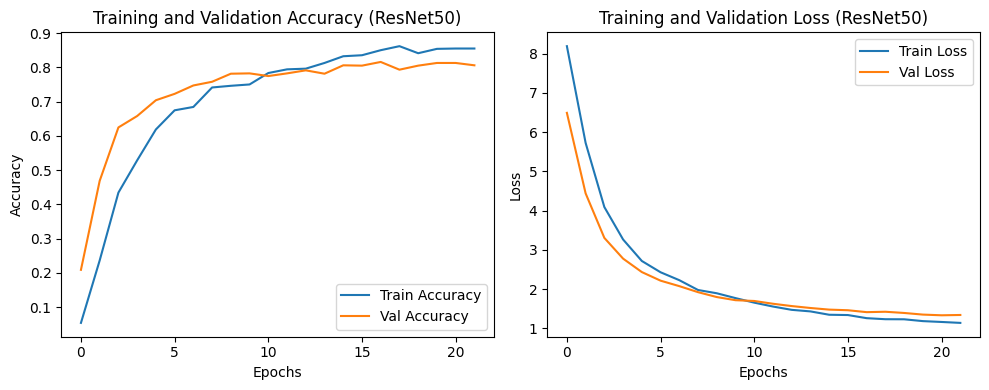

In [43]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_resnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (ResNet50)')
plt.legend()

# Plot loss
plt.subplot(1,2,2)
plt.plot(history_resnet.history['loss'], label='Train Loss')
plt.plot(history_resnet.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (ResNet50)')
plt.legend()

plt.tight_layout()
plt.show()


In [44]:
#VGG16
history_vgg = model_vgg.fit(
    train_ds_vgg,
    validation_data = val_ds_vgg,
    epochs = 25,
    callbacks = callbacks
)

Epoch 1/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 328ms/step - accuracy: 0.0203 - loss: 10.9245 - val_accuracy: 0.1059 - val_loss: 7.0866 - learning_rate: 0.0010
Epoch 2/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 291ms/step - accuracy: 0.1217 - loss: 6.8204 - val_accuracy: 0.2441 - val_loss: 5.8257 - learning_rate: 0.0010
Epoch 3/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 288ms/step - accuracy: 0.2284 - loss: 5.6850 - val_accuracy: 0.3882 - val_loss: 4.7845 - learning_rate: 0.0010
Epoch 4/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 286ms/step - accuracy: 0.3601 - loss: 4.6973 - val_accuracy: 0.4735 - val_loss: 4.0494 - learning_rate: 0.0010
Epoch 5/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 285ms/step - accuracy: 0.4775 - loss: 4.0897 - val_accuracy: 0.5490 - val_loss: 3.5640 - learning_rate: 0.0010
Epoch 6/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 290ms/step - accuracy: 0.5526 - loss: 3.4822 - val_accuracy: 0.5873 - val_loss: 3.1859 - learning_rate: 0.0010
Epoch 7/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 292ms/step - accuracy: 0.6293 - loss: 3.1115

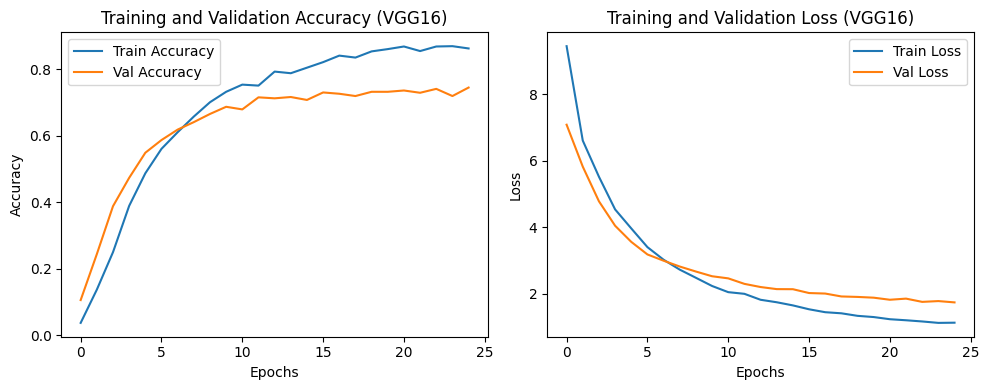

In [45]:
# Plot accuracy
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_vgg.history['accuracy'], label='Train Accuracy')
plt.plot(history_vgg.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (VGG16)')
plt.legend()

# Plot loss
plt.subplot(1,2,2)
plt.plot(history_vgg.history['loss'], label='Train Loss')
plt.plot(history_vgg.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (VGG16)')
plt.legend()

plt.tight_layout()
plt.show()


In [46]:
#MobileNetV2
history_mobilenet = model_mobilenet.fit(
    train_ds_mobile,
    validation_data = val_ds_mobile,
    epochs = 25,
    callbacks = callbacks
)

Epoch 1/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 198ms/step - accuracy: 0.0291 - loss: 8.6625 - val_accuracy: 0.1275 - val_loss: 6.9000 - learning_rate: 0.0010
Epoch 2/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 0.1318 - loss: 6.4547 - val_accuracy: 0.3667 - val_loss: 5.1552 - learning_rate: 0.0010
Epoch 3/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.3107 - loss: 4.8287 - val_accuracy: 0.4941 - val_loss: 4.0622 - learning_rate: 0.0010
Epoch 4/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.4379 - loss: 3.9124 - val_accuracy: 0.5784 - val_loss: 3.3878 - learning_rate: 0.0010
Epoch 5/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - accuracy: 0.5279 - loss: 3.1652 - val_accuracy: 0.6098 - val_loss: 3.0443 - learning_rate: 0.0010
Epoch 6/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.6023 - loss: 2.8893 - val_accuracy: 0.6294 - val_loss: 2.7725 - learning_rate: 0.0010
Epoch 7/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.6215 - loss: 2.5567 -

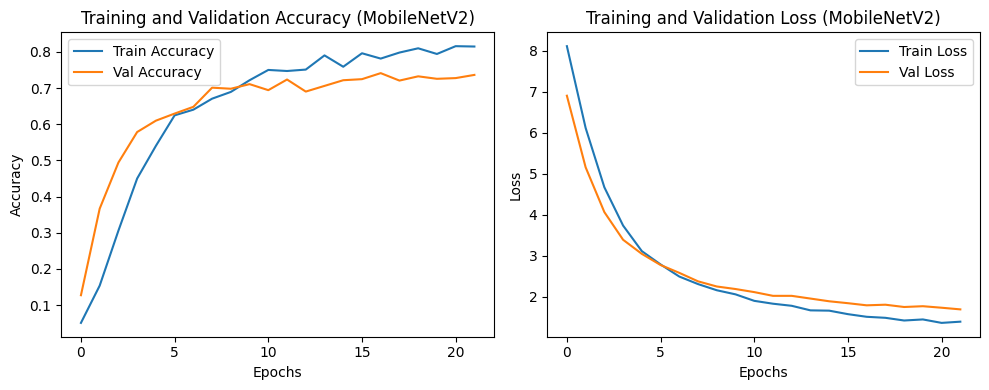

In [47]:
# Plot accuracy
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_mobilenet.history['accuracy'], label='Train Accuracy')
plt.plot(history_mobilenet.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (MobileNetV2)')
plt.legend()

# Plot loss
plt.subplot(1,2,2)
plt.plot(history_mobilenet.history['loss'], label='Train Loss')
plt.plot(history_mobilenet.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (MobileNetV2)')
plt.legend()

plt.tight_layout()
plt.show()


In [48]:
test_loss_resnet, test_acc_resnet = model_resnet.evaluate(test_ds_resnet)
print(f"ResNet50 Test Loss: {test_loss_resnet:.4f} | Test Accuracy: {test_acc_resnet:.4f}")


193/193 ━━━━━━━━━━━━━━━━━━━━ 27s 137ms/step - accuracy: 0.7559 - loss: 1.5760
ResNet50 Test Loss: 1.5538 | Test Accuracy: 0.7660


In [49]:
test_loss_vgg, test_acc_vgg = model_vgg.evaluate(test_ds_vgg)
print(f"VGG16 Test Loss: {test_loss_vgg:.4f} | Test Accuracy: {test_acc_vgg:.4f}")


193/193 ━━━━━━━━━━━━━━━━━━━━ 28s 145ms/step - accuracy: 0.7111 - loss: 1.9501
VGG16 Test Loss: 1.9308 | Test Accuracy: 0.7141


In [50]:
test_loss_mobile, test_acc_mobile = model_mobilenet.evaluate(test_ds_mobile)
print(f"MobileNetV2 Test Loss: {test_loss_mobile:.4f} | Test Accuracy: {test_acc_mobile:.4f}")


193/193 ━━━━━━━━━━━━━━━━━━━━ 14s 70ms/step - accuracy: 0.6945 - loss: 1.9621
MobileNetV2 Test Loss: 1.9461 | Test Accuracy: 0.7022


# **Assignment Questions/Tasks:**

## 1) Which model performed best on the Oxford Flowers 102 dataset and why?
- ResNet50 had the highest test accuracy at 0.7660, followed by VGG16 at 0.7141 and MobileNetV2 at 0.7022.
ResNet50 performed best because its architecture is deeper and it uses residual connections, which help the model learn more complex flower features and avoid vanishing gradients. This results in stronger generalization despite the small dataset size.


## 2) Compare the performance of the models on Oxford Flowers 102 to their performance on CIFAR-100 (from the original notebook). What differences do you observe and why?
- On Oxford Flowers 102, all three models achieved higher test accuracy than typically seen with CIFAR-100.
This may be because the flower dataset, though challenging, consists of images that are larger and contain more distinct textures and color patterns, which pre-trained ImageNet backbones recognize well.
CIFAR-100, with its smaller image size and more random objects, is harder for transfer directly from ImageNet features.


## 3) Discuss the effect of transfer learning on this dataset.
- Transfer learning enabled strong performance with relatively little training data by leveraging features already learned from ImageNet.
If the models had been trained from scratch on Oxford Flowers 102, their accuracy would be much lower and would likely overfit.
Transfer learning allowed the models to generalize well, with minimal overfitting after fine-tuning and augmentation.


## 4) Explain the steps you took for data preprocessing and why they were necessary.
- Resizing: All images were resized to 224x224 to match the input size for pre-trained models.

- Preprocessing: Used model-specific input normalization (ResNet50, VGG16, MobileNetV2) to make image pixel values compatible with the way each model was originally trained.

- One-hot encoding: Labels were converted to one-hot format so models can perform multiclass classification.

- Batching and prefetching: Used for efficient GPU utilization and fast training.

These steps ensure that the data is compatible with ImageNet backbones, aids convergence, and prevents runtime errors or sub-optimal learning.


## 5) Describe the model architectures you used and how you adapted them for the Oxford Flowers 102 dataset.
Used pre-trained versions of ResNet50, VGG16, and MobileNetV2:

- The original classification layers were replaced with a GlobalAveragePooling2D, a dense layer with ‘relu’ activation, Dropout for regularization, and a final Dense layer with softmax activation for 102 flower classes.

- Data augmentation was applied as the first layer.

- The pre-trained base was frozen during initial training and optionally unfrozen for fine-tuning.

This approach allowed reuse of powerful features from ImageNet while adapting each model to the flower dataset’s specific classification task.

## 6) What challenges did you encounter during this assignment and how did you address them?
- Overfitting: Solved by adding data augmentation, dropout, and early stopping, and by fine-tuning only the top layers.

- Slow initial learning: Monitored training curves and adjusted learning rates as needed.

- Compatibility: Ensured preprocessing matched the requirements of each backbone model.

Regular monitoring of validation curves and iterative tuning of hyperparameters allowed the issues to be addressed rapidly.



# Conclusion

All three transfer learning models—ResNet50, VGG16, and MobileNetV2—showed high accuracy on the Oxford Flowers 102 dataset, with ResNet50 achieving the best test accuracy and generalization.
Effective data preprocessing, regularization, and progressive fine-tuning were crucial for avoiding overfitting and making the most of the pre-trained features.
Transfer learning proved to be a powerful approach for flower classification, dramatically outperforming what would be possible from training on this dataset from scratch.